In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import io
from textblob import Word
import re
import sys, os, csv
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter


In [2]:
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vishnu Vardhan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Vishnu
[nltk_data]     Vardhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Vishnu
[nltk_data]     Vardhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Cleaning

In [ ]:
def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower())
dictionary = Counter(words(open('dataset/wordlists/merged.txt').read()))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def prep(tweet):
    """pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", str(tweet))
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', str(tweet))
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    tweet = tweet.strip()"""
    
    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    tweet = re.sub('\d+', '', str(tweet))
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)     
        
    ps = PorterStemmer()
    words = tweet.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    tweet = " ".join(lemma_words)
    
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = tweet.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    tweet = " ".join(clean_words)
    
    tweet = tweet.strip()
    return tweet

def vectorise_label(label):
    if label == "empty":return 0
    elif label == "sadness":return 2
    elif label == "enthusiasm":return 1
    elif label == "neutral":return 0
    elif label == "worry":return 2
    elif label == "surprise":return 1
    elif label == "love":return 3
    elif label == "fun":return 1
    elif label == "hate":return 4
    elif label == "happiness":return 1
    elif label == "boredom":return 0
    elif label == "relief":return 1
    elif label == "anger":return 4
    elif label == "b*tch": return 4
    elif label == "fu*k": return 4

In [ ]:
data1 = pd.read_csv("C:\\Users\\Vishnu Vardhan\\Desktop\\capstone project file\\crawled_csv\\processors\\capstonesad_processes.csv",sep=",")
dataWriter = csv.writer(open('crawled_csv/prep/capstonesad_prep.csv', 'w'), delimiter=',',lineterminator="\n")
total = 2000
for i in range(2000):
    tweet= prep(data1.iloc[:,0][i])
    dataWriter.writerow([tweet, 2])     
print("Done!")

In [ ]:
data2 = pd.read_csv('dataset/data/text_emotion.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data2.shape)
print(data2.sentiment[0],":",data2.content[0])

In [ ]:
dataWriter = csv.writer(open('cleaned_data/capstonedata_prep.csv', 'w', encoding='utf-8'), delimiter=',',lineterminator="\n")

total = 40000
for i in range(40000):
    tweet= prep(data2.content[i])
    dataWriter.writerow([tweet, str(vectorise_label(data2.sentiment[i]))])
       
print("Progress: ",100,"\nComplete!")

MODEL BULIDING


In [4]:
data_train = pd.read_csv('C:\\Users\\Vishnu Vardhan\\Desktop\\capstone project file\\cleaned_data\\training.csv', sep=',')
print("Dataset shape:",data_train.shape)

Dataset shape: (16000, 2)


In [5]:
data_train['label'] += 1

In [6]:
data_train.head()

,text,label
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,4
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,4


Text(0.5, 0, 'Emotions')

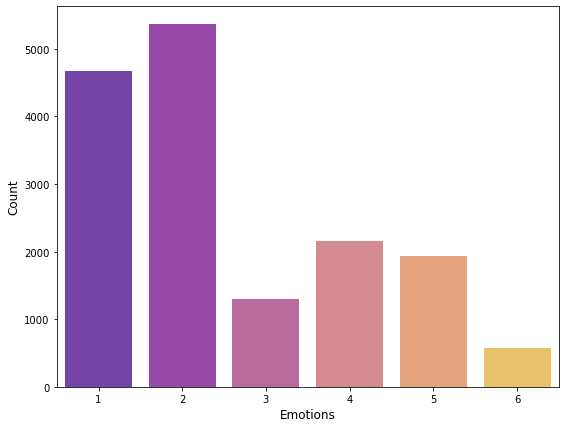

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

count = data_train.iloc[:,1].value_counts()
fig = plt.figure(figsize=(9,7))  # Rename plt to fig
sns.barplot(x = count.index, y = count.values, alpha=0.8, palette="plasma")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)

#sadness (1)
#joy (2)
#love (3)
#anger (4)
#fear (5)
#neutral (6)

# Test Train Split

In [8]:
X_train = data_train.iloc[:,0][:11199]
#[:47583]
y_train = data_train.iloc[:,-1][:11199]
#[:47583]
X_val = data_train.iloc[:,0][11200:]
#[47584:]
y_val = data_train.iloc[:,-1][11200:]
#[47584:]

# Count Vectorizer

In [9]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_train.iloc[:,0].astype('U'))
X_train_count =  count_vect.transform(X_train.astype('U'))
X_val_count =  count_vect.transform(X_val.astype('U'))
print(count_vect.vocabulary_)

{'didnt': 3642, 'feel': 4943, 'humiliated': 6448, 'can': 1910, 'go': 5694, 'from': 5404, 'feeling': 4947, 'so': 12298, 'hopeless': 6359, 'to': 13616, 'damned': 3233, 'hopeful': 6357, 'just': 7270, 'being': 1216, 'around': 729, 'someone': 12366, 'who': 14800, 'cares': 1980, 'and': 524, 'is': 7028, 'awake': 957, 'im': 6572, 'grabbing': 5750, 'minute': 8447, 'post': 10144, 'greedy': 5811, 'wrong': 15031, 'am': 462, 'ever': 4589, 'nostalgic': 9050, 'about': 60, 'the': 13419, 'fireplace': 5073, 'will': 14843, 'know': 7432, 'that': 13412, 'it': 7053, 'still': 12713, 'on': 9253, 'property': 10423, 'grouchy': 5849, 'ive': 7070, 'been': 1182, 'little': 7808, 'burdened': 1798, 'lately': 7536, 'wasnt': 14636, 'sure': 13046, 'why': 14818, 'was': 14629, 'taking': 13203, 'or': 9313, 'milligrams': 8406, 'times': 13578, 'recommended': 10819, 'amount': 492, 'fallen': 4841, 'asleep': 795, 'lot': 7910, 'faster': 4887, 'but': 1833, 'also': 443, 'like': 7738, 'funny': 5462, 'as': 773, 'confused': 2702, 'li

(16000, 15180)


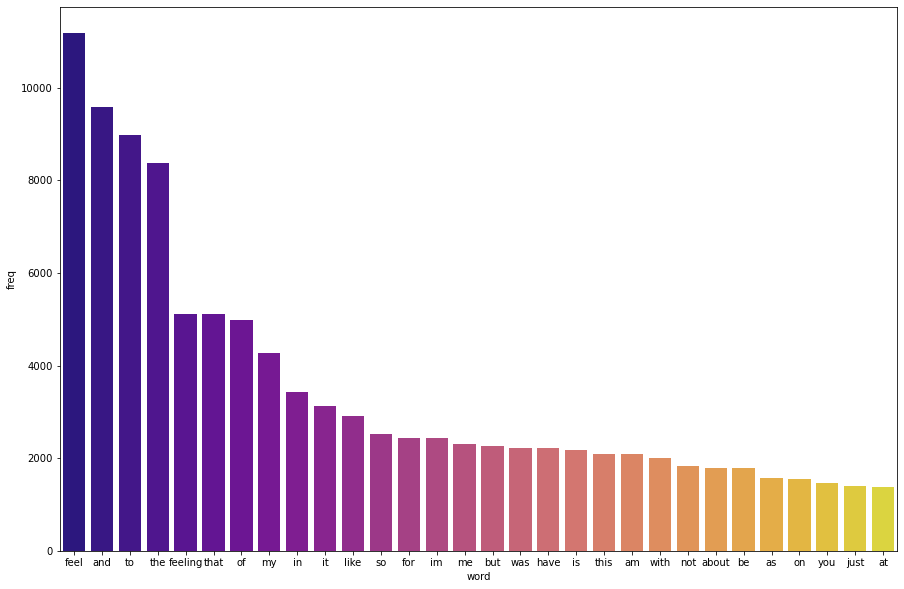

In [10]:
bow = count_vect.fit_transform(data_train.iloc[:,0].astype('U'))
print(bow.shape)
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

# Building models using different classifiers (Count vectorizer)

In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

if you have a binary classification problem where the positive class is underrepresented in the data, then you may encounter a ValueError when computing the precision or recall for the positive class. This is because the evaluation metric is computed using the number of true positives, false positives, or false negatives for the positive class, and if there are very few positive examples in the data, then the count of these quantities may be zero.

To avoid this issue, you can try using the average parameter in the evaluation metric functions. The average parameter specifies how to compute the metric when there are multiple classes. By setting average to weighted, you can account for the class imbalance in the data.


In [ ]:
nb1 = MultinomialNB()
nb1.fit(X_train_count, y_train)
y_pred = nb1.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_nb = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_nb)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
nb1.fit(X_train_count, y_train)
y_pred_proba = nb1.predict_proba(X_val_count)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='red', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic for multiclass')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_nb.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Navie bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [12]:
logreg1 = LogisticRegression(C=1, max_iter=500)
logreg1.fit(X_train_count, y_train)
y_pred = logreg1.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_lr = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_lr)
print("Classification report:\n", class_report)

Accuracy: 0.8835416666666667
Confusion matrix:
 [[1313   51    4   30   30    2]
 [  36 1472   49    7    7    7]
 [   8   76  288    5    1    0]
 [  42   41    4  549   19    1]
 [  30   19    2   18  502   22]
 [  10   14    0    2   22  117]]
Classification report:
               precision    recall  f1-score   support

           1       0.91      0.92      0.92      1430
           2       0.88      0.93      0.91      1578
           3       0.83      0.76      0.79       378
           4       0.90      0.84      0.87       656
           5       0.86      0.85      0.86       593
           6       0.79      0.71      0.75       165

    accuracy                           0.88      4800
   macro avg       0.86      0.83      0.85      4800
weighted avg       0.88      0.88      0.88      4800



In [ ]:
from sklearn.metrics import roc_auc_score

# Fit the logistic regression model and predict on validation set
logreg1 = LogisticRegression(C=1, max_iter=500)
logreg1.fit(X_train_count, y_train)
y_pred_prob = logreg1.predict_proba(X_val_count)

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')

# Print ROC AUC score
print("ROC AUC score:", roc_auc)



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
logreg1.fit(X_train_count, y_train)
y_pred_proba = logreg1.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_logreg.png')
plt.show()




In [ ]:
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix LOGISTIC REGRESSION')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_for_logreg.png')
plt.show()

In [ ]:
lsvm1 = SGDClassifier(alpha=0.001, random_state=5, max_iter=2, tol=None,loss='modified_huber')
lsvm1.fit(X_train_count, y_train)
y_pred = lsvm1.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_lvsm = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_lvsm)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
lsvm1.fit(X_train_count, y_train)
y_pred_proba = lsvm1.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_lvsm1.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_lvsm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Linear svm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svclinear = SVC(kernel='linear', C=1000,probability=True)
svclinear.fit(X_train_count, y_train)
y_pred = svclinear.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_svcl = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_svcl)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
svclinear.fit(X_train_count, y_train)
y_pred_proba = svclinear.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_svclinear.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_svcl, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVC LINEAR')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
svcrbf = SVC(kernel='rbf', C=1000,probability=True)
svcrbf.fit(X_train_count, y_train)
y_pred = svcrbf.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_rbf = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_rbf)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
svcrbf.fit(X_train_count, y_train)
y_pred_proba = svcrbf.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_svcrbf.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_rbf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVC RBF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
Rf = RandomForestClassifier(n_estimators=10,max_features='auto',random_state=101)
Rf.fit(X_train_count, y_train)
y_pred = Rf.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_rf = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_rf)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
Rf.fit(X_train_count, y_train)
y_pred_proba = Rf.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_Rf.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix RANDOM FOREST')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
Dt = DecisionTreeClassifier()
Dt.fit(X_train_count, y_train)
y_pred = Dt.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_dt = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_dt)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
Dt.fit(X_train_count, y_train)
y_pred_proba = Dt.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_Dt.png')
plt.show()

In [ ]:
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix DECISON TREE')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
print(y_pred)

bagging

In [ ]:
rfcb = RandomForestClassifier(n_estimators=10, bootstrap=True)
rfcb.fit(X_train_count, y_train)
y_pred = rfcb.predict(X_val_count)
accuracy = accuracy_score(y_val, y_pred)
conf_matrix_rfcb = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix_rfcb)
print("Classification report:\n", class_report)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert y_val to binary format
n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

# Train and predict on the validation set
rfcb.fit(X_train_count, y_train)
y_pred_proba = rfcb.predict_proba(X_val_count)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curves for multi-class classification')
#plt.legend(loc="lower right")
plt.savefig('ROC_GRAPH_for_rfcb.png')
plt.show()



In [ ]:
sns.heatmap(conf_matrix_rfcb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix RANDOM FOREST BAGGING')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
x_values = ['SVM','RANDOMFOREST','DECISIONTREE','NAVIEBAYES','LOGISTICREGRESSION','SVCLINEAR','SVCRBF(Radial Basis Function)','RANDOMFORESTBAGGING']
y_values = [85,80,86,72,88,84,81,81]
fig, ax = plt.subplots()
ax.bar(x_values, y_values)
ax.set_xlabel('MODEL NAMES')
ax.set_ylabel('ACCURACIES')
ax.set_xticklabels(x_values, rotation=90)
plt.savefig('accuracies1.jpg')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Data
x_values = ['SVM','RANDOMFOREST','DECISIONTREE','NAVIEBAYES','LOGISTICREGRESSION','SVCLINEAR','SVCRBF(Radial Basis Function)','RANDOMFORESTBAGGING']
y_true = np.array([1, 0, 1, 0, 1, 1, 0, 1]) # true labels (1 = positive, 0 = negative)
y_scores = np.array([0.85, 0.8, 0.86, 0.72, 0.88, 0.84, 0.81, 0.81]) # predicted scores (probabilities)

# Calculate ROC curve for each model
fprs = []
tprs = []
aucs = []
for i in range(len(x_values)):
    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

# Plot ROC curves
plt.figure()
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
for i in range(len(x_values)):
    plt.plot(fprs[i], tprs[i], label='{} (AUC = {:.2f})'.format(x_values[i], aucs[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("roc cruve of all graphs.png")
plt.show()


In [13]:
import pickle

In [14]:
with open("model.pkl", 'wb') as file:
    pickle.dump(logreg1, file)

In [16]:
tweets = pd.DataFrame(["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
       ])

tweet_count = count_vect.transform(tweets[0])

In [17]:
#Predicting the emotion of the tweet 
tweet_pred = logreg1.predict(tweet_count)
print(tweet_pred)
tweets[0]

[2 2 5 4 1 2 1 2 2 2 1 2 2 1 1 1]


0     For instance, giving a kiss to your younger si...
1     Love is the key to happiness. We all want to l...
2     One day I was studying in my room when, all of...
3                             I am so angry at you!!!!!
4     you ve hit a new low with a danger of blm fasc...
5                                       I love my doggg
6                        I think i'm gonna be sick :'‑(
7                                    I hate you so much
8                                           I'm at work
9     @TheTombert i was watching Harpers Island, lol...
10    sometimes i wish things could go back to the w...
11         it's your 18th birthday finally!!! yippeeeee
12                                still waiting in line
13    aarrgghh - fu*k.....a hose has leaked water al...
14                                that b*tch is so ugly
15                          oh no he is hospitalised!!!
Name: 0, dtype: object

In [19]:
final_result=tweets.copy()

In [20]:
final_result['result']=tweet_pred
final_result=final_result.rename(columns={0:"tweets"})
final_result=final_result.rename(columns={"result":"predicted_emotion"})
final_result=final_result.replace({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'neutral'})
final_result

,tweets,predicted_emotion
0,"For instance, giving a kiss to your younger si...",love
1,Love is the key to happiness. We all want to l...,love
2,"One day I was studying in my room when, all of...",neutral
3,I am so angry at you!!!!!,fear
4,you ve hit a new low with a danger of blm fasc...,joy
5,I love my doggg,love
6,I think i'm gonna be sick :'‑(,joy
7,I hate you so much,love
8,I'm at work,love
9,"@TheTombert i was watching Harpers Island, lol...",love


In [21]:
import pickle
from flask import Flask,request, jsonify,render_template

In [22]:
app = Flask(__name__)

In [23]:
model = pickle.load(open("model.pkl", "rb"))

In [24]:
@app.route('/')
def home():
    return render_template('home.html')

In [25]:
@app.route('/templates/result.html')
def results():
    return render_template('templates/result.html')

In [26]:
def prediction_emotion(tweets):
    tweet_count = count_vect.transform(tweets)
    tweet_pred = model.predict(tweet_count)
    final_result=tweets.copy()
    final_result=final_result.rename(columns={0:"tweets"})
    final_result=final_result.rename(columns={"result":"predicted_emotion"})
    final_result=final_result.replace({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'neutral'})

In [27]:
from flask import jsonify

@app.route('/predict', methods=['POST'])
def predict():
    text = request.form['text']
    prediction = prediction_emotion(text)
    return jsonify({'result': prediction})

In [29]:
if __name__ == "__main__":
    app.run()
   

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
